In [1]:
%matplotlib inline

In [2]:
import argparse
import os
import sys

import matplotlib.pyplot as plt
import numpy as np

import cpc.feature_loader as fl
import cpc.train as tr
from cpc.dataset import AudioBatchData, findAllSeqs, filterSeqs, parseSeqLabels

In [3]:
sys.path.append(os.path.dirname(tr.__file__))

In [4]:
CP = '/pio/scratch/2/jch/wav2vec/runs/cpc_base/ls100_cpcctc_match12_pred8/checkpoint_199.pt'

In [5]:
cdata = fl.getCheckpointData(os.path.dirname(CP))
_, _, args = cdata
args.pathDB = '/pio/data/zerospeech2021/LibriSpeech-wav/train-clean-100'
args.pathTrain = '/pio/scratch/2/jch/wav2vec/LibriSpeech100_labels_split/train_split.txt'
args.pathVal = '/pio/scratch/2/jch/wav2vec/LibriSpeech100_labels_split/test_split.txt'
args.pathPhone = '/pio/scratch/2/jch/wav2vec/LibriSpeech100_labels_split/converted_aligned_phones.txt'
args.size_window = 20480

seqNames, speakers = findAllSeqs(args.pathDB,
                                 extension=args.file_extension,
                                 loadCache=not args.ignore_cache)
phone_labels, n_phones = parseSeqLabels(args.pathPhone)

seq_val = filterSeqs(args.pathVal, seqNames)[:10]
db_val = AudioBatchData(args.pathDB, args.size_window, seq_val,
                        phone_labels, len(speakers))

model, args.hiddenGar, args.hiddenEncoder = fl.loadModel([CP])
assert args.speakerEmbedding == 0
criterion = tr.loadCriterion(CP, model.gEncoder.DOWNSAMPLING, len(speakers), None)

Loaded from cache /pio/data/zerospeech2021/LibriSpeech-wav/train-clean-100/_seqs_cache.txt successfully


10it [00:00, 72440.48it/s]

Checking length...
Done, elapsed: 0.023 seconds
Scanned 10 sequences in 0.02 seconds
1 chunks computed


Joining pool
Joined process, elapsed=1.850 secs
Loading checkpoint /pio/scratch/2/jch/wav2vec/runs/cpc_base/ls100_cpcctc_match12_pred8/checkpoint_199.pt
Loading the state dict at /pio/scratch/2/jch/wav2vec/runs/cpc_base/ls100_cpcctc_match12_pred8/checkpoint_199.pt
!!!!!!!!!USING CPCCTC!!!!!!!!!!!!


In [6]:
model.cpu()
criterion.cpu()
val_loader = db_val.getDataLoader(1, 'sequential', False, numWorkers=0)

In [7]:
data_iter = iter(val_loader)

In [8]:
batch_data, label = next(data_iter)
c_feature, encoded_data, _ = model(batch_data, None)

# cFeature: after the autoregressive model
# encoded_data: output of the encoder

losses, outAcc, crit_locals = criterion(c_feature, encoded_data, label, return_locals=True)

In [9]:
crit_locals['log_scores'].shape

torch.Size([116, 12, 8])

In [11]:
crit_locals['log_scores'].shape

torch.Size([116, 12, 8])

tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2, 31, 31, 31])


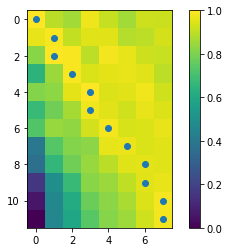

In [10]:
O = 
print(label[0, O:O + args.CPCCTCNumMatched])
plt.imshow(crit_locals['log_scores'][O].detach().numpy())
plt.scatter(crit_locals['aligns'][O, :], np.arange(args.CPCCTCNumMatched))
plt.colorbar()